In [1]:
import sys
sys.path.append('../')

import numpy as np

from fmodeling.ForwardProcessing1D import forward_with_trace_calcing
from inversion.Strategies.SeismDiffInversion1D import inverse
from inversion.optimizators.optimizations import LBFGSBOptimization, DifferentialEvolution, TrustKrylov, TrustConstr, \
    ConjugateGradient, AxOptimizer
from Tests.test_ForwardProcessing1D import get_model_2layered, get_model_3layered
from Data.geol_models import get_model_3layered_fluid_rp_dicts
from objects.Data.WavePlaceholder import OWT, WaveDataPlaceholder
from objects.Models.Models import SeismicModel1D
from objects.Attributes.RockPhysics.RockPhysicsAttribute import RockPhysicsAttribute
from objects.Attributes.Seismic.SeismicAttribute import SeismicAttribute
from objects.Models.Layer1D import Layer1D, LayerOPT
import time

from matplotlib import pyplot as plt
from inversion.Strategies.SeismDiffInversion1D import func_to_optimize


In [2]:
from Visualization.Seismic import visualize_seismogram
from scipy.optimize import approx_fprime


In [3]:
def plot_1D_err(forward_params, nvals, min_max=None, dot=False, vline_x=None):
    
    if min_max is None:
        min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
        max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
        
    else:
        min_val = np.array([min_max[0]])
        max_val = np.array([min_max[1]])
    
    dval = (max_val - min_val) / nvals

    val_x = [min_val + dval*i for i in range(nvals+1)]
    errs = []
    for val in val_x:
        errs.append(func_to_optimize(val, placeholders, forward_params, helper=None, show_tol=False))
        
    plt.plot(val_x, errs)
    if dot:
        plt.plot(val_x, errs, 'o')
        
    if vline_x is not None:
        plt.vlines(vline_x, ymin=min(errs), ymax=max(errs), colors='r')
        
    plt.show()

def optimization_func_2D(forward_params, x, y):
    indexes_1 = np.arange(x.shape[0])
    indexes_2 = np.arange(x.shape[1])
    
    Z = np.zeros((x.shape[0], x.shape[1]))
    
    for ind1 in indexes_1:
        for ind2 in indexes_2:
            Z[ind1, ind2] = func_to_optimize([x[ind1, ind2], y[ind1, ind2]], placeholders, forward_params, helper=None, show_tol=False)
        
    return Z

def plot_2D_err(forward_params, nvals, ncontous=10, points=None):
    min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
    max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
    
    dval = (max_val - min_val) / nvals

    val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
    val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

    X, Y = np.meshgrid(val_1_x, val_2_x)

    Z = optimization_func_2D(forward_params, X, Y)
    
    plt.contourf(X, Y, Z, ncontous, cmap='seismic')
    plt.colorbar()
    
    if points is not None:
        plt.plot(points[0], points[1], marker='o', color='green', markersize=5)

# Четырехслойная модель с газоосадками

In [4]:
h = [
    67.5,
    22.5,
    20
]

In [38]:
layer_1_seism = {
    'vp': 1500,
    'vs': 700,
    'rho': 1000
}

layer_2_rp = {
    "name": "unconsolidated",
    "components": {
                    "Ksi": {
                      "value": 38,
                      "optimize": True,
                      "min": 20,
                      "max": 60
                    },
					"Gsi": {
                      "value": 44,
                      "optimize": True,
                      "min": 20,
                      "max": 50
                    },
					"rhosi": {
                      "value": 2.2,
                      "optimize": True,
                      "min": 2,
                      "max": 2.5
                    },
                    "Ksh": {
                      "value": 21.5,
                      "optimize": True,
                      "min": 10,
                      "max": 50
                    },
					"Gsh": {
                      "value": 7,
                      "optimize": True,
                      "min": 1,
                      "max": 20
                    },
					"rhosh": {
                      "value": 2.43,
                      "optimize": True,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kincl": {
                      "value": 36.9,
                      "optimize": False,
                      "min": 35,
                      "max": 40
                    },
                    "Gincl": {
                      "value": 31,
                      "optimize": False,
                      "min": 30,
                      "max": 35
                    },
                    "rhoincl": {
                      "value": 2.2,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kfl": {
                      "value": 2.29,
                      "optimize": False,
                      "min": 0.5,
                      "max": 5
                    },
                    "rhofl": {
                      "value": 1,
                      "optimize": False,
                      "min": 0.5,
                      "max": 1.5
                    },
#                     "Vsi": {
#                       "value": 0.01,
#                       "optimize": False,
#                       "min": 0.5,
#                       "max": 0.99
#                     },
                    "Vsh": {
                      "value": 0.7,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "Vincl": {
                      "value": 0,
                      "optimize": False,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "phi": {
                      "value": 0.74,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    }
                  }
}

layer_3_seism = {
    'vp': 2000,
    'vs': 1000,
    'rho': 2070
}

# посмотреть в дипломе Машки!
layer_4_seism = {
    'vp': 6600,
    'vs': 3600,
    'rho': 2600,
}

In [39]:
optimization_list = [
#     "Ksi",
#     "Gsi",
#     "rhosi",
    "Ksh",
    "Gsh",
#     "rhosh",
#     "Kfl",
#     "rhofl",
    "Vsh",
#     "Vincl",
    "phi"
]

for key in layer_2_rp['components'].keys():
    if key in optimization_list:
        layer_2_rp['components'][key]["optimize"] = True
        
    else:
        layer_2_rp['components'][key]["optimize"] = False

In [40]:
layer_1 = Layer1D(h[0],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_1_seism),
                  opt=LayerOPT.NO)
layer_2 = Layer1D(h[1],
                  rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
                  seism_attribute=None,
                  opt=LayerOPT.RP)
layer_3 = Layer1D(h[2],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_3_seism),
                  opt=LayerOPT.NO)
layer_4 = Layer1D(-1,
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_4_seism),
                  opt=LayerOPT.NO)

In [41]:
model = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])

In [42]:
# Многоканальная коса

In [43]:
dx = 2
nx = 100
x_rec = [i * dx for i in range(1, nx+1)]
wave_types = [OWT.PdPu_water]
dt = 1e-04
tracelen = 2000

# Forward modeling

In [44]:
observe, test_seismic = \
    forward_with_trace_calcing(model, x_rec,
                               dt=dt, trace_len=tracelen, wavetypes=wave_types, display_stat=True,
        visualize_res=False, visualize_seismograms=False)

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu_water-rays...


In [45]:
true_vals = model.get_optimization_option('val')

In [46]:
true_vals

OrderedDict([(1, {'Ksh': 21.5, 'Gsh': 7, 'Vsh': 0.7, 'phi': 0.74})])

In [47]:
model.layers[0].seism_attribute.vals_dict

{'vp': 1500, 'vs': 700, 'rho': 1000}

In [48]:
model.layers[1].seism_attribute.vals_dict

{'vp': 1534.1089459244965, 'vs': 200.08822703140874, 'rho': 1353.8600000000001}

# Inversion

In [49]:
forward_params = {
    "model": model,
    "x_rec": x_rec,
    "dt": dt,
    "trace_len": tracelen,
    "wavetypes": wave_types,
    "display_stat": False,
    "visualize_res": False
}

## Create start indexes

In [50]:
def formula(v, h, x):
    return np.sqrt(x**2 + 4*h*h) / v

In [51]:
start_times = formula(1500, 60, np.array(x_rec))
start_indexes = (start_times / dt).astype(int)

In [52]:
# fig, ax = plt.subplots(figsize=(12,8))

# visualize_seismogram(fig, ax, test_seismic[OWT.PdPu_water]['seismogram'], wiggles=False)
# ax.plot(x_rec, start_times)
# plt.show()

In [53]:
placeholders = {}
for wt in wave_types:
    placeholders[wt] = WaveDataPlaceholder(
        wt,
        test_seismic[wt]["rays"],
        test_seismic[wt]["seismogram"],
        start_indexes=start_indexes
    )

## Create optimizers

In [54]:
optimizers_de = [
    DifferentialEvolution(
          popsize= 5,
          maxiter= 50000,
          init= "latinhypercube",
          strategy= "best1bin",
          disp= True,
          polish= False,
          tol= 0.00001,
          mutation= 1.5,
          recombination= 0.6,
          workers= 8
    )
]

In [22]:
optimizers_lbfgs = [
    LBFGSBOptimization(
        maxiter=15000,
        maxfun=15000,
        factr=100,
        maxls=50,
        pgtol=1e-7,
        epsilon=1e-7,
        iprint=1,
        disp=1
    )
]

In [23]:
optimizers_cg = [
    ConjugateGradient(
    )
]

In [24]:
optimizers_ax = [
    AxOptimizer(num_evals=50, log_scale=False)
]

In [25]:
min_vals = forward_params['model'].get_optimization_option('min', vectorize=True)
max_vals = forward_params['model'].get_optimization_option('max', vectorize=True)
start_vals = np.random.uniform(min_vals, max_vals)

print(min_vals, max_vals)
print(start_vals)

[0.5 0.5] [0.99 0.99]
[0.94478315 0.54822266]


In [26]:
start_vals = [0.85, 0.7]

In [27]:
forward_params['model'].set_optimization_option(start_vals)

func_to_optimize(forward_params['model'].get_optimization_option('val', vectorize=True), placeholders, forward_params, helper=None, show_tol=False)

/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.28550957735835925

## Check sensitivity

In [59]:
def func_(xk):
    return func_to_optimize(xk, placeholders, forward_params, helper=None, show_tol=False)

def func_min_max(xk):
    xk = min_vals + xk * (max_vals - min_vals)
    
    return func_to_optimize(xk, placeholders, forward_params, helper=None, show_tol=False)

nrepeats = 5

grads = []

for i in range(nrepeats):
    start_vals = np.random.uniform(min_vals, max_vals)
    start_vals_minmax = (start_vals - min_vals) / (max_vals - min_vals)
    
#     grads.append(approx_fprime(start_vals, func_, epsilon=[1e-6]*len(start_vals)))
    grads.append(approx_fprime(start_vals_minmax, func_min_max, epsilon=[1e-6]*len(start_vals)))
    
grads

[array([-0.02389677, -0.00118447,  0.00511412, -0.07431884, -0.01222486,
         0.00653593,  0.03492057,  0.7575626 ]),
 array([-4.24749347e-03, -8.83493279e-05,  1.44636645e-02, -5.81149443e-01,
        -7.33540736e-01,  2.00665568e-01,  2.51103741e-01,  1.19375249e+00]),
 array([ 4.11396750e-03, -1.05365716e-05, -1.22040432e-02,  2.56779170e-02,
        -3.54525004e-02, -4.24796873e-02, -7.71417930e-04,  9.28113112e-02]),
 array([-3.84250498e-03, -2.86084045e-04,  1.64208513e-03, -1.49465619e-01,
        -1.13557008e-02,  2.29438997e-02,  5.07049505e-02,  1.24711769e+00]),
 array([ 4.01821598e-03, -1.63325631e-04,  1.22964465e-02,  1.57634512e-02,
        -1.44172000e-02,  4.02019774e-02,  6.72925271e-04, -3.21535841e-01])]

In [110]:
model.get_optimization_option('val')

OrderedDict([(1, {'Vsh': 0.99, 'phi': 0.99})])

# Run inversion process

In [55]:
scale="minmax"
# scale=None
# scale="lg"

start_time = time.time()
inversed_vals = inverse(optimizers_de, error=None, placeholders=placeholders, forward_params=forward_params, scale=scale)
print(f"time: {time.time() - start_time}")

1.1602629543672753
1.3626894402008443
2.4626998567296163
0.4790803660580526
2.6708615478776063
1.4289259875011204
1.773058786789463
2.593750256451584
0.9135287564580747
3.3494187159592004
4.463487846357278
4.636903941514614
2.894090553403377
2.710491065764161
1.7703934084603472
3.267918649056743
2.970067856989137
1.9790783875629725
3.053634130429705
4.869635446448245
0.4105215905091463
1.7065861321079305
2.2447580274246905
3.543319671490504
0.7038597804382127
0.8107812333639584
2.8702736242838913
4.131640801503504
2.789035624566881
2.9233144909988797
1.3052046907041337
0.24384189311097185
1.9258228010316127
2.0891270233022343
2.3329286246107004
5.002028545909011
1.6669086217230193
2.644814190414656
1.1124418681750852
1.1877939743858534
1.298524288771774
differential_evolution step 1: f(x)= 0.243842
0.4628846186997568
2.4455954259073183
2.9018463811843307
2.8679847558763636
0.6438617722601084
2.419730670631096
2.431770855832612
0.5816715188541759
0.4891299573438098
1.0987946091913126
3.

2.8259103748113024
2.525468353850543
0.6867536574316038
2.734378316579612
0.590362237982893
differential_evolution step 19: f(x)= 0.01979
0.4403017567533791
2.312699736461252
2.7982299360867273
0.3583033840868909
1.1888872756814033
2.056158443537766
0.7453007788812241
2.4862782178130565
1.973320098398851
2.6775144723994946
3.109407321761354
1.1357537121584087
3.3369331271596754
0.7243575598141969
1.4925715364830245
1.8939060337047084
2.7250658855230636
1.7395836204068575
1.619866264298807
0.326984350787763
1.707619901578675
differential_evolution step 20: f(x)= 0.01979
2.2772517265811127
2.3208267075229623
0.5689697409816947
1.298798063964678
2.9666173026852705
0.429021046970518
0.9273403377584422
2.8984190977158693
0.9406478518113394
0.2865145965390594
3.0377236740281934
0.6963743409964578
0.6314466072949083
1.6836694915831658
4.9963741367468355
0.43568027416551636
1.2465177016971436
2.724563501864791
2.2924824332516374
differential_evolution step 21: f(x)= 0.01979
5.160925575019853
0

1.4285760097387332
2.1091827374647703
0.5326512761260966
2.4612187205198497
3.2113153315691254
1.085796352349071
2.2899060739276513
4.389756037565216
2.406557547289846
1.7904674610592333
0.6030444432944815
1.8428277013593788
2.332184456394328
1.4728789788791885
2.5238825860215957
1.2347540095994023
3.2542818466099974
differential_evolution step 39: f(x)= 0.01979
2.856957109375963
2.896747592846536
2.8619734318489694
5.195079524426444
2.582375241551352
0.89137075190621
2.4764907256973094
2.4938706708316714
0.2946861381854054
0.7948448690703731
3.933496320316634
0.1820989092163788
2.8355250099473888
2.7653288189487317
1.7807332669910272
1.5570562039689841
1.1647900186111053
1.9125289224293407
2.735204040305458
4.238908979269371
differential_evolution step 40: f(x)= 0.01979
0.8147839616846325
1.5859434613203403
1.6677671251625283
3.0845008778636567
4.444892038554147
1.002175747465339
0.13315473643561707
2.538529373836143
0.8931613279989634
2.5094286844650004
0.7144441589835748
1.852303931

2.771473463138442
2.2002511924916037
2.3975614800741933
0.7362524184064874
2.2359365743348656
4.47944804010578
0.1963621208766385
differential_evolution step 58: f(x)= 0.01979
1.0687051455889705
2.657141075319174
0.45968837761284326
2.8442191555553915
0.965886670255849
2.8196232742071534
0.9888250911572221
1.086487447534208
2.38630009399562
1.3899549604966976
2.4268476528231377
2.600667419090384
1.3219069496501081
2.829852280422869
1.6910869323920017
2.3420873264226385
0.7983382393225483
1.7331705187582571
2.5391132460751815
2.5065249848984346
1.8172145792209298
differential_evolution step 59: f(x)= 0.01979
0.25829468559333624
2.8898908840043216
2.615183377215055
2.4262031083562814
2.552421128290303
1.1367531531954174
2.7933937637914052
1.673716880874578
1.9762025145893636
1.3257680572650579
2.4604477034983616
0.8370581375873677
2.8408578561796984
1.4433833721047726
1.773856543948757
2.601676293731923
1.7246503652357417
2.445646603246502
0.37312351947423616
2.707005599507299
differenti

1.9169101723878386
0.7500667777152358
2.9328875393396308
1.3950671857652446
1.1882204781383632
0.4635194681320315
0.6697742626765716
2.6664306061813527
1.5370321240485791
0.17482202690634224
0.8901305414372432
2.276992940584095
0.0828557936042001
1.0013763690942596
0.2648695913828487
2.7268108967735034
1.366335915101789
0.1185189872227897
2.2764640647527536
1.957539103842742
differential_evolution step 78: f(x)= 0.0134046
1.788493622738844
2.4142277848843525
2.395258415113218
2.458080842505427
0.7771826812434539
2.7719422402426317
0.25281143080163654
2.739046476612786
1.0175398178466302
2.8539077570753637
0.11668024544649128
1.6151368333544571
1.7613544990209369
0.6031753227846425
2.305762534213467
0.522269284519227
2.4993556023939094
1.9393322129499173
1.599902448306893
0.357873474340153
differential_evolution step 79: f(x)= 0.0134046
1.840621155484473
0.2948458017907111
1.4266153545928535
1.636092158506376
0.22690069266597254
0.6616936981168858
1.6637189210565169
0.9624293688857548
3

0.13662667678159415
0.7413203204520656
0.22366404870411954
1.0135303756663174
1.683034084959212
1.6534079959144965
0.7364651375943719
1.0108056919477384
3.1117349079642884
0.3409531141073596
1.494838050306339
1.2059513160792985
2.8313517364254435
0.1982807009449642
differential_evolution step 97: f(x)= 0.00333087
1.9363939121121225
1.1459588082749437
1.6456091696555728
1.0226622881639063
2.1801708196197787
0.7615213981154231
1.1711577271265552
2.1129566740349137
1.2079065101525504
2.4870275251112197
0.6201422472339507
2.811106226458441
0.2244928752235298
0.5892091363983175
2.0888654586704725
0.43082580892463784
2.2240618044701144
1.645537978580468
0.5973979429999485
0.501061672471729
differential_evolution step 98: f(x)= 0.00333087
1.162231168676813
0.19778216315174765
2.840527696891808
1.925521188332186
0.23083127701221184
1.4590635075121616
2.295809144128549
1.779903426020821
1.261024684259794
0.1136265830327614
1.8807128486824483
2.608887942528205
0.08089521146685039
2.9487415373000

2.6494215106709675
2.1740353519104896
2.888307827079648
2.5368397238336065
3.3009518538049485
2.8678603110102996
2.4170090496661154
0.16047511007991755
1.1768487864334536
differential_evolution step 116: f(x)= 0.00333087
2.2355550791029972
0.49831270415778284
2.017029035577822
2.442329936587972
3.2433621102246133
0.5117753720714907
2.361659341099361
2.328998684691087
1.909714350174576
1.4887547986654626
0.8085396904126346
2.139477091446057
1.4273795428961886
2.769386430523627
1.9512635628005
2.221174271202857
0.8752260027903412
2.6159677029765054
0.4152966236028329
0.5882648049683527
0.8273870405838476
differential_evolution step 117: f(x)= 0.00333087
0.09624771818471378
1.4174613300306602
0.15632792101542914
2.725988201070614
0.16292856645304368
1.1692727087239134
1.46925755103439
0.5494811211414637
0.6183602647134914
0.2517891985149061
2.698995817535774
1.8380934065479813
1.9739787871337324
0.12229181141008934
0.8826016971938038
2.623019998909778
2.3259522117121736
1.5158538512562443

0.3565794949039749
0.757952331148222
0.5612480327361284
0.7433564316953477
1.2617468710346063
differential_evolution step 135: f(x)= 0.00333087
2.89464325505257
0.15100707096251198
2.3238143071029853
0.564978265103093
2.8847040542852604
2.7236955056007037
0.26705916314902006
1.0121650235757897
0.3796783988050551
0.7972631689375732
0.037603282759000226
0.12562064877490162
0.5425774247101838
2.4986303597394945
0.501032068307945
0.48784020365599
0.042629043881787385
1.3387999581066103
0.52710604571211
0.3134912660454165
differential_evolution step 136: f(x)= 0.00333087
0.06339566901672727
0.8505820215514783
2.869680275302471
0.5069023594450829
2.776944351748243
1.3197486954791857
0.3690407939313604
2.4722619510415136
0.07026939062825806
0.042629043881787385
0.9426400565394556
3.053033809102223
2.9708416570278766
2.9163215180416433
2.412925092421647
0.7839885760958051
0.2947935430075657
0.5165199011957828
0.933288353096813
0.4440114555139995
differential_evolution step 137: f(x)= 0.0033308

0.6726033915532229
2.5281272974544184
0.020847539811092504
1.470562392890938
1.4549548228832723
0.07292380387302716
differential_evolution step 154: f(x)= 0.00333087
0.7346517775397354
0.14374515825781814
0.8160863584079902
0.26020781452498504
0.09144021539771832
0.4534688260418807
0.5349701975596064
1.1992745696393559
0.4400387708284192
1.0381181931726242
1.5522275021278524
0.4423403269800009
0.016015260020415794
0.46378522855366017
0.36294336511092384
0.5098810597793441
1.582650348795682
0.3596747835931771
1.0266333024800771
0.21375191359519974
differential_evolution step 155: f(x)= 0.00333087
2.2145568969702607
1.1319014291489866
0.059587890565131946
0.5825642569743835
0.1496375106315411
0.8744774479978843
0.2051386635546163
0.943218495576479
1.2431824444810182
1.4224855653937276
0.6120886181447691
0.42469632271347857
0.18370145766798293
0.0547860269453234
0.2797161123915232
0.6630352760875747
2.3157633898484127
0.5126758570327884
1.9001990341140322
1.2178289557695368
differential_e

0.021681052621302644
0.495025933252732
0.29667228066818235
0.659365017971638
0.13511008136388478
0.017773829254357706
0.11649402545123896
0.25987864235740527
0.9972294223386057
0.38722433054799604
0.02830816222766427
0.2108209565359448
0.3262917140390485
differential_evolution step 173: f(x)= 0.00333087
0.029551213399816062
0.5635498589375854
0.05712026572645933
0.017076973418681404
0.12828082550864106
0.10469257116639813
0.071931332252796
0.21460536632714852
0.253716977880631
0.061953246620533954
0.3363844541723485
0.04957196258725272
0.5361191023443522
0.4470934068050313
0.017215122915633978
0.37590085035908805
0.16850927194801443
1.06237292025163
1.1623065987805878
0.13173661047266977
differential_evolution step 174: f(x)= 0.00333087
0.05779867902824986
0.07510478698079515
0.06589250228080436
0.425057230609776
0.1972207717686267
0.45772819710497115
0.48017229864985383
0.7616594190691645
0.1978921532042795
0.5884788935238923
0.05736002948357361
0.3539539430444832
1.1062554102270075
0

0.32458019054515497
0.011937557843264
0.05035792306888249
0.12272403871286679
0.1300210413445625
0.35999792750451537
0.00988617331926343
0.1884401571137078
0.01780326725392298
0.6807506154236015
0.14871431214393982
0.055893670288191415
0.27564254042472547
0.4778245275732536
0.3638172835667483
1.1160306089380287
0.4251236502264489
0.13684488185033966
0.3763997000380172
0.02937529603690412
differential_evolution step 192: f(x)= 0.00333087
0.05332071118342681
0.141182571063751
0.31666274474009765
1.089071666823591
0.5158510382143568
0.036086734712706035
1.243174923979019
0.13548696896455198
1.117247748050579
0.03084192075658746
0.06430722748105207
0.5709193021904434
0.10944955828720644
0.9757072931894929
0.49916591699102253
0.5288528773575306
0.530988675893037
0.2536757514124312
0.19440171249940383
0.26863395242853744
0.49253162665483247
differential_evolution step 193: f(x)= 0.00333087
0.9407511866078007
0.22947067474302202
0.2336329708718906
0.40365840359576194
0.021413985189008358
0.92

0.05364522266567695
0.7438736040946611
1.7628839309205075
0.09794344407511442
0.1813124933702985
0.24305760679335456
differential_evolution step 210: f(x)= 0.00333087
0.6043044046281314
0.064089175365167
0.3091574860443643
0.058522890368962015
0.4436277582091532
1.0738392376866757
0.08304838453035178
0.33214059662056244
2.1521189021136213
0.130385917049736
1.4782508455557895
0.3328189773478623
0.16233791270795173
2.192138911363146
0.4847715227810082
0.12790251435991637
0.05714541071936094
0.7583862069269616
0.1253237865163532
2.2803452296455973
differential_evolution step 211: f(x)= 0.00333087
0.16870829446368293
0.16413301884747292
0.9518815263116931
0.12163700066796598
0.516567400279438
0.44980579022606565
0.4829823787434453
0.12660513866171522
0.014341504598318627
0.6640497675333206
0.2772548485836508
0.3746103620870824
0.33133669227657014
0.7932341882931625
0.3256393600659965
0.6613774478257404
0.8544878118496471
0.21943383762117558
0.01564322640407585
1.037010778147727
differentia

0.18476932021345577
0.25183616370749046
0.21429805474193436
0.6633917518343084
0.2509251709662617
1.0549863683863119
0.3521151506730313
0.7703268522434205
1.526413916664211
0.9396286306197923
0.1815476624774932
0.05817481121714482
differential_evolution step 229: f(x)= 0.00333087
0.5463813912200013
0.15685593383690857
0.289794797524292
2.2288518237053583
2.146839037606098
0.43453791943713854
0.922464058819096
1.4081330582371865
0.25065131809775265
0.8707975487120663
0.07022166936908024
2.2965475737394616
1.7942299643446653
0.44029984107441367
0.026703266566292374
0.4885222660911969
0.025417348906059564
0.07397008328478534
0.44239666261597976
0.2538539577188513
differential_evolution step 230: f(x)= 0.00333087
0.7970413665142652
0.1795457559516685
0.7456796642388211
0.5062572414922044
0.6037222194372447
1.1529328141285824
0.07389302285136654
0.16298955449532282
0.0356855506050287
0.04288545259097884
0.3809990305919128
0.06758048578737175
1.6345634106235494
1.084690640617235
0.4389941607

0.0170400628969224
0.2128883710966702
0.029085472987816757
0.0962972905788735
0.7210908724015207
0.19621440959447797
0.45015523532729423
0.4137674773112765
2.418355189539715
0.026703266566292374
0.15046891068415613
1.1660992313943035
0.26450069994987024
0.3676410951314208
1.1487560240805696
0.44912071384376584
0.04944125483066438
differential_evolution step 248: f(x)= 0.00333087
0.13866130964373138
0.2912089467692569
0.06785885364922827
0.8879840832395629
1.0135069473764597
0.9635380444037868
2.07004499234541
0.0603367301225789
0.49504653678489685
0.47355271958454404
0.9063070492970587
0.4322691014171339
0.5214095884342523
0.011328826058144737
0.2746608196094729
0.3823827565347583
0.2511495172845143
0.901400981474637
0.9281211357335016
1.495441605154833
0.11119091720989151
differential_evolution step 249: f(x)= 0.00333087
0.447636462721899
0.05952085685377577
1.7799584830428392
0.5519133273521142
1.3586098874427492
0.019634268958548338
1.311971172096486
0.04084713610046834
0.3324375705

differential_evolution step 266: f(x)= 0.00333087
0.3093375925445869
1.0673725958824276
0.5323233173318418
0.07760834151061259
0.1500730696851129
0.44364951911688216
0.13498634974669269
0.5833423230091158
0.9275606759681281
1.4934068564447696
0.43992537953484184
1.1459636586168933
2.129615648756276
0.33239995738593625
0.6517057276160667
0.7373073367358219
0.2990840816955949
0.022293903764598715
0.13387808417961275
differential_evolution step 267: f(x)= 0.00333087
0.3713371989536517
0.12544503508580634
0.12661944372840322
1.3389546965781558
0.3425120267597532
0.006654888152559989
0.4027350118655705
0.4471547667476486
1.429349979190932
1.0216847717681434
0.9721653598623186
0.34412271412141276
0.011416154863156289
0.17067020491611704
0.13361461887802636
1.3753723224835803
0.5592569459537813
0.021295415867077203
1.5189664515148122
0.6638630885168395
differential_evolution step 268: f(x)= 0.00333087
0.42090971982685604
1.5565115732449157
0.5759455315122288
0.7672646201009249
0.5238578728609

0.21071117468302958
1.3866427788202529
1.527705353518519
differential_evolution step 285: f(x)= 0.00295478
0.9122169214087953
0.8373519322904314
0.1655445300390474
1.2330005093590422
0.8103216690073649
1.7255911758508389
2.352314826448984
2.2269183589045425
0.35034217879397583
0.03356385867140387
0.37784332085327105
1.4880567029702445
1.1431889208785742
0.057938456346138936
0.02690939051244276
0.8638546988170778
1.8641927237863414
0.07305459777047771
0.2890896726646536
0.29589581994708536
differential_evolution step 286: f(x)= 0.00295478
1.0536664402535263
2.411317821750522
1.4729980386366792
0.5426714248881429
0.936807098123447
0.2791358756718032
0.05406516294979433
0.06637860701529272
0.09282118609195408
0.7426949097964655
1.5944125467082846
0.8897642572203479
0.42537897245811934
0.4137853511292384
0.44980078942046764
0.49177955573113863
0.30894504169097814
0.0760081345313559
0.3032782850069844
0.28815724495435047
differential_evolution step 287: f(x)= 0.00295478
0.33348650562108934


1.305892278089742
0.5241916758982561
1.64639341400676
2.2177071703690916
0.4724313258320548
0.1512061781670305
differential_evolution step 304: f(x)= 0.00295478
0.26337124204324475
0.33635930939477704
0.18824243170024957
1.2995539622616847
0.35021369842602107
2.0512278722599864
0.15368173627931303
0.37125513361626467
1.1282556697188324
0.8623819234890328
0.4040678515733394
0.05719126272739507
0.402363151313858
0.3231596078066099
1.145577796122611
1.427223664121937
0.46423105770476025
1.8243005763043927
0.7704798375089358
0.3476662784168621
differential_evolution step 305: f(x)= 0.00295478
0.05376979702322458
0.5653871489904432
1.9914537875696963
0.06637860701529272
0.6817632385210715
0.4325217900402819
0.05580198130234785
0.8895193306915691
0.05457796678083923
0.411166655426461
0.15150434260674672
0.07192642439901976
0.9296732424837816
0.2626964890583759
0.8996481981666985
0.4133698363505611
0.1797077086739778
0.054965773737467256
0.017076837634639956
1.4680363903173637
differential_ev

0.5242332695150116
0.4782061945773014
0.08604533990096747
0.5121131653175404
0.9848299270537662
2.6585468587427274
0.7130566702910617
2.949759187665905
0.8992805300595408
differential_evolution step 323: f(x)= 0.00292744
0.7505115072139799
0.051943539366962305
1.7651683537218947
0.7892817994223275
0.08706330765337597
0.5023620063497992
0.13103147808144372
1.9767934390278317
0.05506964886836386
0.18566671117530414
2.8938682979028214
1.06032094348356
0.02468370886410019
0.3388745737651278
0.12300602913465274
0.1900496009790597
0.027474889479104276
0.7046522211577141
0.0796851619185305
0.4298005222883243
differential_evolution step 324: f(x)= 0.00292744
0.38454844755810585
0.2113891699739323
0.27979518693970357
1.304884124611875
1.044039243357856
1.8610626084328297
0.2633990823071793
0.061099494175276145
0.8953444445985604
0.4414978409496729
0.14473378820187163
1.290542393586922
0.023353753923873403
3.1546466350813094
0.25714792001874814
2.366582921474762
1.1707441605822368
0.123894155070

1.1354702954623517
1.6852298768182483
0.32807129765618603
0.22464367962827908
1.0381098052091553
0.07081200499845369
0.023914328177219602
0.13413732785303775
0.00292743903220105
0.15792901766023273
2.000171705058915
0.9545992691669083
0.9944613151024567
differential_evolution step 342: f(x)= 0.00292744
0.14756089016631868
0.16047010676092674
0.46614797484929205
0.6580880497522953
0.1794977104569617
0.4565035028315522
3.1879501895948303
2.3244027405081518
1.2202190050264714
0.1783499719108159
2.871965202573681
0.3218383200755214
1.6346471492896362
0.03602746492758793
1.3557109921395376
0.15932411315565936
0.5492661693506061
0.0051510588034444195
0.8600242716922863
0.0053362576997327315
differential_evolution step 343: f(x)= 0.00292744
0.4220438645484849
0.4591071890414763
0.9354825676082473
0.4080005029572836
0.48153791212634534
0.5197530126364245
2.3111807437280056
0.7372265383543358
0.06461987840009245
0.01738643554740902
0.7711639437787572
0.622486905130085
0.4827396306331519
0.13314

0.903497600076448
0.12420738028472302
0.2907659049122008
0.6085609327944724
0.6112326700236682
2.3439476058017057
1.0174809247088763
0.15162399304132912
0.1783499719108159
0.7651655153717208
0.006444184040791585
0.5208126789871785
0.45504014938591425
0.757762316582273
0.6269323056688365
0.46667011335800573
0.010517347101529058
0.2036656255943421
differential_evolution step 361: f(x)= 0.00292744
1.4064024107156496
0.006444184040791585
0.006444184040791585
0.399527343134911
0.06149331649146394
2.200127931729741
0.48305023194152713
1.9447190449759404
0.8885539252269792
0.6372213058935925
0.04993239559576548
0.06716145427453693
0.02667199606674758
1.0075356358735803
0.16602738468741848
0.0377848338365036
0.20017772827737906
1.4555567716910849
0.25626706139408256
0.15252193097999084
differential_evolution step 362: f(x)= 0.00292744
1.1947435081397761
0.29278542152154685
0.7671940497587962
0.502423797782854
0.46908594251062274
1.2376450122466849
0.008130754675914434
0.024139159123817432
0.39

0.00292743903220105
0.00292743903220105
differential_evolution step 379: f(x)= 0.00292744
0.00292743903220105
0.6774605034957268
0.1334140450838788
0.18021428547350166
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.7341339647815684
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
differential_evolution step 380: f(x)= 0.00292744
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.49405859182780837
0.8761867558185319
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.00292743903220105
0.11003080571658329
0.00292743903220105
0.00292743903220105
differential_evolution step 381: f(x)= 0.00292744
0.002927439032

In [56]:
forward_params['model'].set_optimization_option(inversed_vals)
forward_params['model'].scale=None
inversed_vals = forward_params['model'].get_optimization_option('val', vectorize=True)

In [57]:
inversed_vals

array([20.97276901,  7.74875627,  0.70386841,  0.73970948])

In [58]:
result = {key: {
    "real": val,
    "inversed": inv
} for key, val, inv in zip(true_vals[1].keys(), true_vals[1].values(), inversed_vals)}
result

{'Ksh': {'real': 21.5, 'inversed': 20.972769008378627},
 'Gsh': {'real': 7, 'inversed': 7.748756274413579},
 'Vsh': {'real': 0.7, 'inversed': 0.7038684078039625},
 'phi': {'real': 0.74, 'inversed': 0.7397094808933711}}

In [103]:
plot_1D_err(forward_params, 100, vline_x=inversed_model)

NameError: name 'inversed_model' is not defined

In [103]:
func_to_optimize(inversed_vals, placeholders, forward_params, helper=None, show_tol=False)

0.0001808107759296082

In [ ]:
res_observe, res_seismic = forward_with_trace_calcing(forward_params['model'], forward_params['x_rec'], 
                           dt=forward_params['dt'], 
                           trace_len=forward_params['trace_len'], 
                           wavetypes=forward_params['wavetypes'],
            display_stat=True, visualize_res=False,
                               visualize_seismograms=True
            )

In [ ]:
diff = test_seismic[OWT.PdPu_water]['seismogram'] - res_seismic[OWT.PdPu_water]['seismogram']
fig, ax = plt.subplots(figsize=(12,8))

visualize_seismogram(fig, ax, diff, wiggles=False)
plt.show()

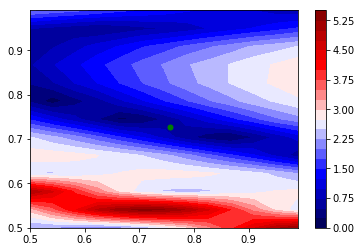

In [122]:
plot_2D_err(forward_params, [12, 12], 20, points=[[inversed_vals[0]], [inversed_vals[1]]])

# Second step optimization